In [132]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import configparser
from deap import creator, base, tools, algorithms

In [2]:
sys.path.append('../../src/')
import apdft
from apdft.calculator.mrcc import MrccCalculator
import apdft.physics as ap

In [13]:
def get_modepn(coordinates, fn):
    #return np.zeros(len(coordinates))
    density = MrccCalculator._parse_densityfile(fn)
    modepns = []
    for site in coordinates:
        ds = np.linalg.norm(density[:, :3] - site* ( 1 / 0.52917721067), axis=1)
        
        modepns.append(np.sum(density[:, 3] * density[:, 4] / ds))
    return modepns
def read_meta(basepath):
    nuclear_charges, coordinates = apdft.read_xyz('%s/inp.xyz' % basepath)
    config = configparser.ConfigParser()
    config.read('%s/apdft.conf' % basepath)
    includeonly = [int(_) for _ in config['apdft']['apdft_includeonly'].strip('[]').split(', ')]
    return nuclear_charges, coordinates, includeonly
def read_coefficients(basepath, nuclear_charges, coordinates, includeonly):
    N = len(includeonly)
    
    coefficients = np.zeros((1 + N*2 + N * (N - 1), N))
    
    # order 0
    pos = 0
    coefficients[pos, :] = get_modepn(coordinates[includeonly], '%s/QM/order-0/site-all-cc/DENSITY' % basepath)
    pos += 1
    
    # order 1
    for site in includeonly:
        coefficients[pos, :] = get_modepn(coordinates[includeonly], '%s/QM/order-1/site-%d-up/DENSITY' % (basepath,site))
        coefficients[pos+1, :] = get_modepn(coordinates[includeonly], '%s/QM/order-1/site-%d-dn/DENSITY' % (basepath,site))
        pos += 2
    
    # order 2
    for site_i in includeonly:
        for site_j in includeonly:
            if site_j <= site_i:
                continue
            
            coefficients[pos, :] = get_modepn(coordinates[includeonly], '%s/QM/order-2/site-%d-%d-up/DENSITY' % (basepath,site_i, site_j))
            coefficients[pos+1, :] = get_modepn(coordinates[includeonly], '%s/QM/order-2/site-%d-%d-dn/DENSITY' % (basepath,site_i, site_j))
            pos += 2
    
    return coefficients

basepath = 'data/coronene-dimer/mrcc-monomer-fast'
nuclear_charges_part, coordinates_part, includeonly_part = read_meta(basepath)
#coefficients = read_coefficients(basepath, nuclear_charges, coordinates, includeonly)
coefficients_part = np.load('%s/coefficients.npy' % basepath)
basepath = 'data/coronene-dimer/mrcc-fast'
nuclear_charges_whole, coordinates_whole, includeonly_whole = read_meta(basepath)
#coefficients = read_coefficients(basepath, nuclear_charges, coordinates, includeonly)
coefficients_whole = np.load('%s/coefficients.npy' % basepath)

In [4]:
def predict_part(includeonly, coefficients, deltaZ):
    N = len(includeonly)
    
    # build alphas
    alphas = np.zeros((1 + N*2 + N * (N - 1)))
    
    # order 0
    alphas[0] = 1
    
    # order 1
    for siteidx in range(N):
        alphas[1 + siteidx*2] += 5 * deltaZ[siteidx]
        alphas[1 + siteidx*2+1] -= 5 * deltaZ[siteidx]
    
    # order 2
    pos = 1 + N*2 - 2
    for siteidx_i in range(N):
        for siteidx_j in range(siteidx_i, N):
            if siteidx_i != siteidx_j:
                pos += 2
            if deltaZ[siteidx_j] == 0 or deltaZ[siteidx_i] == 0:
                continue
            if includeonly[siteidx_j] > includeonly[siteidx_i]:
                prefactor = 2 * (200/6.) * deltaZ[siteidx_i]*deltaZ[siteidx_j]
                alphas[pos] += prefactor
                alphas[pos+1] += prefactor
                alphas[0] += 2*prefactor
                alphas[1 + siteidx_i*2] -= prefactor
                alphas[1 + siteidx_i*2+1] -= prefactor
                alphas[1 + siteidx_j*2] -= prefactor
                alphas[1 + siteidx_j*2+1] -= prefactor
            if includeonly[siteidx_j] == includeonly[siteidx_i]:
                prefactor = (400/6.) * deltaZ[siteidx_i]*deltaZ[siteidx_j]
                alphas[0] -= 2*prefactor
                alphas[1 + siteidx_i*2] += prefactor
                alphas[1 + siteidx_j*2+1] += prefactor
    
    # calculate energy
    return np.sum(np.multiply(np.outer(alphas, deltaZ), coefficients))

## Production

In [19]:
def get_dnn(includeonly, coordinates, nuclear_charges):
    dnn = []
    for site in includeonly:
        q = nuclear_charges.copy()
        q[site] += 1
        dnn.append(ap.Coulomb.nuclei_nuclei(coordinates, q) - ap.Coulomb.nuclei_nuclei(coordinates, nuclear_charges))
    return np.array(dnn)
dnn_part = get_dnn(includeonly_part, coordinates_part, nuclear_charges_part)
dnn_whole = get_dnn(includeonly_whole, coordinates_whole, nuclear_charges_whole)

In [154]:
def predict(deltaZ_A):
    if abs(sum(deltaZ_A)) > 1e-4:
        return 1e6
    E_A = -predict_part(includeonly_part, coefficients_part, deltaZ_A)+ (dnn_part * deltaZ_A).sum()
    E_B = 0
    
    E_AB = -predict_part(includeonly_whole, coefficients_whole, deltaZ_A) + (dnn_whole * deltaZ_A).sum()
    
    E_int = E_AB - E_A - E_B
    
    return (E_int,)

In [157]:
predict([1, -1, 0, 1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

(0.07888885899433262,)

In [195]:
def optimize(bnpairs, minimize=True, pop=100, generations=200):
    if minimize:
        creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    else:
        creator.create("FitnessMin", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)
    def random_individual(nbnpairs):
        a = ([1, -1] * nbnpairs + [0, 0] * (12 - nbnpairs))
        np.random.shuffle(a)
        return creator.Individual(a)
    def twoPointExchange(a, b):
        def _do(a, b):
            vals = [_ for _ in a if _ != 0.]
            offspring = []
            for idx in range(len(a)):
                if b[idx] != 0:
                    try:
                        offspring.append(vals.pop(0))
                    except:
                        print (sum(a), sum(b))
                        raise
                else:
                    offspring.append(0)
            return offspring
        return creator.Individual(_do(a, b)), creator.Individual(_do(b, a))
    toolbox = base.Toolbox()
    toolbox.register("individual", random_individual, bnpairs)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("evaluate", predict)
    toolbox.register("mate", twoPointExchange)
    toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=pop)
    NGEN=generations
    progress = []
    best = []
    for gen in range(NGEN):
        offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.1)
        fits = toolbox.map(toolbox.evaluate, offspring)
        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit
        population = toolbox.select(offspring, k=len(population))
        top = tools.selBest(population, k=1)[0].fitness
        progress.append(top.values[0])
        best.append(list(tools.selBest(population, k=1)[0]))
        print (progress[-1], best[-1])
    #return progress, best

In [194]:
p, r = optimize(8, False, pop=20, generations=10)

0.6600544613140755 [0, 1, -1, -1, 1, 1, 1, -1, 0, -1, 0, -1, -1, 0, -1, 1, 1, -1, 0, 1, 0, 0, 0, 1]
0.7707770878841984 [0, 0, -1, 1, -1, 0, 1, 1, 1, -1, 0, -1, -1, -1, 1, 0, -1, -1, 0, 1, 0, 1, 1, 0]
1.0668830486899878 [0, 0, -1, 0, 0, -1, 1, 1, 1, -1, -1, -1, 1, 1, 0, -1, 0, 0, -1, 1, 1, 0, -1, 1]
1.0668830486899878 [0, 0, -1, 0, 0, -1, 1, 1, 1, -1, -1, -1, 1, 1, 0, -1, 0, 0, -1, 1, 1, 0, -1, 1]
1.184800112679568 [0, 0, -1, 0, 0, -1, 1, 1, 0, -1, -1, -1, 1, 1, 0, -1, 1, 0, -1, 1, 1, 0, -1, 1]
1.0668830486899878 [0, 0, -1, 0, 0, -1, 1, 1, 1, -1, -1, -1, 1, 1, 0, -1, 0, 0, -1, 1, 1, 0, -1, 1]
1.1045430457625116 [0, 0, -1, 1, 0, -1, 1, 0, 1, -1, -1, -1, 1, 1, 0, -1, 0, 0, -1, 1, 1, 0, -1, 1]
1.1045430457625116 [0, 0, -1, 1, 0, -1, 1, 0, 1, -1, -1, -1, 1, 1, 0, -1, 0, 0, -1, 1, 1, 0, -1, 1]
1.3575897529992744 [0, 0, -1, 1, 0, -1, 1, -1, 1, -1, -1, -1, 1, 1, 0, -1, 1, 0, -1, 1, 1, 0, 0, 0]
1.3575897529992744 [0, 0, -1, 1, 0, -1, 1, -1, 1, -1, -1, -1, 1, 1, 0, -1, 1, 0, -1, 1, 1, 0, 0, 0]


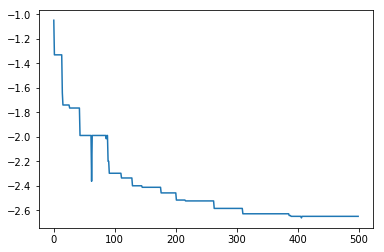

In [180]:
plt.plot(p)

In [196]:
len(r[0])

24